# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE

%matplotlib inline

In [163]:
# Read MobileCustomerChurn
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [141]:
# Examine the data: check number of rows and number of columns
churn.shape

(46206, 21)

In [142]:
# A description of all of the variable names.
Dictionary = pd.read_csv("files/MobileChurnDataDictionary.csv")
Dictionary.head(21)

,column_Number,Variable_name,Description
0,1,CUST_ID,Unique customer identifier
1,2,ACCOUNT_TENURE,Account tenure in months based on last day of ...
2,3,ACCT_CNT_SERVICES,Total number of services under an account
3,4,AGE,Age of the account holder (derived on dob)
4,5,CFU,Customer facing unit derived based on owning c...
5,6,SERVICE_TENURE,Service tenure in months
6,7,PLAN_ACCESS_FEE,Monthly access fee payable for the plan exclud...
7,8,BYO_PLAN_STATUS,Whether the customer is on a BYO (bring your o...
8,9,PLAN_TENURE,Plan tenure in months
9,10,MONTHS_OF_CONTRACT_REMAINING,Contract tenure remaining based on months of c...


**CLEANED DATA**

According to the churn dataframe, the last three columns (RECON_SMS_NEXT_MTH, RECON_TELE_NEXT_MTH, and RECON_EMAIL_NEXT_MTH) are mainly made up of missing values, and therefore these columns will not be included in this prediction. 

The other columns in churn will be examined for missing values, and if there are any, they will be dealt in the following lines: 			

In [143]:
# Drop the last three columns (RECON_SMS_NEXT_MTH, RECON_TELE_NEXT_MTH, RECON_EMAIL_NEXT_MTH) as well as customer_id
churn=churn.drop(['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH','RECON_EMAIL_NEXT_MTH','CUST_ID'], axis=1)

In [144]:
# Analysing the percentage of missing values
pd.DataFrame(((churn.isnull().sum()/len(churn)) * 100).reset_index()).rename(columns={'index':'COL',0:'%MISSING'})

,COL,%MISSING
0,ACCOUNT_TENURE,0.000000
1,ACCT_CNT_SERVICES,0.000000
2,AGE,0.164481
3,CFU,0.000000
4,SERVICE_TENURE,0.000000
5,PLAN_ACCESS_FEE,0.000000
6,BYO_PLAN_STATUS,0.000000
7,PLAN_TENURE,0.000000
8,MONTHS_OF_CONTRACT_REMAINING,0.000000
9,LAST_FX_CONTRACT_DURATION,0.000000


In [145]:
churn[['AGE','STATE','COUNTRY_METRO_REGION']].isna().sum()

AGE                     76
STATE                    1
COUNTRY_METRO_REGION     1
dtype: int64

There are 76 missing entries in the AGE column, and 1 missing value in each of the STATE and COUNTRY METRO REGION columns. Since  there is just 1 missing value in STATE and COUNTRY METRO REGION, these NaN values can be removed; however, the 76 NaN values in AGE will be replaced with the mean values.

In [146]:
# Replace missing Age values with the mean value 
# Remove the only instance where the state and country metro region are missing.
churn.AGE.fillna(churn.AGE.mean(),inplace=True)
churn.dropna(subset = ["COUNTRY_METRO_REGION"], inplace=True)
churn.dropna(subset = ["STATE"], inplace=True)

In [147]:
# Using the dummies method, convert categorical values to numerical values.
categorical_features=[col for col in churn.columns if churn[col].dtypes=='O']
categorical_features

['CFU',
 'BYO_PLAN_STATUS',
 'CONTRACT_STATUS',
 'HANDSET_USED_BRAND',
 'COUNTRY_METRO_REGION',
 'STATE']

In [148]:
# Taking our categorical values and convert them into numerical inputs
for col in categorical_features:
    churn[col] = churn[col].astype('category')
    churn[col] = churn[col].cat.codes

In [149]:
# Display the names of the columns in the churn dataset
churn.columns

Index(['ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'CFU', 'SERVICE_TENURE',
       'PLAN_ACCESS_FEE', 'BYO_PLAN_STATUS', 'PLAN_TENURE',
       'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION',
       'CONTRACT_STATUS', 'PREV_CONTRACT_DURATION', 'HANDSET_USED_BRAND',
       'CHURN_IND', 'MONTHLY_SPEND', 'COUNTRY_METRO_REGION', 'STATE'],
      dtype='object')

In [150]:
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,
1,46,1,30.0,0,46,54.54,1,15,0,24,1,24,4,1,61.40,0,7
2,60,3,55.0,0,59,54.54,1,5,0,24,1,24,0,1,54.54,1,1
3,65,1,29.0,0,65,40.90,0,15,0,12,1,12,0,1,2.50,0,7
4,31,1,51.0,0,31,31.81,1,31,0,24,1,24,0,1,6.48,0,6
5,95,1,31.0,0,95,54.54,1,0,0,24,1,24,0,1,100.22,1,1


In [151]:
# Divide the dataset into features and target variables.
y = churn['CHURN_IND']
X = churn.drop(columns='CHURN_IND')

In [152]:
print ('Our features column are :',X.columns.values)

Our features column are : ['ACCOUNT_TENURE' 'ACCT_CNT_SERVICES' 'AGE' 'CFU' 'SERVICE_TENURE'
 'PLAN_ACCESS_FEE' 'BYO_PLAN_STATUS' 'PLAN_TENURE'
 'MONTHS_OF_CONTRACT_REMAINING' 'LAST_FX_CONTRACT_DURATION'
 'CONTRACT_STATUS' 'PREV_CONTRACT_DURATION' 'HANDSET_USED_BRAND'
 'MONTHLY_SPEND' 'COUNTRY_METRO_REGION' 'STATE']


In [155]:
# Scale your data
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)

# Split our data into Train and test 
X_train, X_test, y_train, y_test = train_test_split(
         X_scaled, y, test_size=0.25, random_state=42)

In [156]:
# Building our logistic regression model 
model = LogisticRegression(random_state = 0,)
model.fit(X_scaled, y)

LogisticRegression(random_state=0)

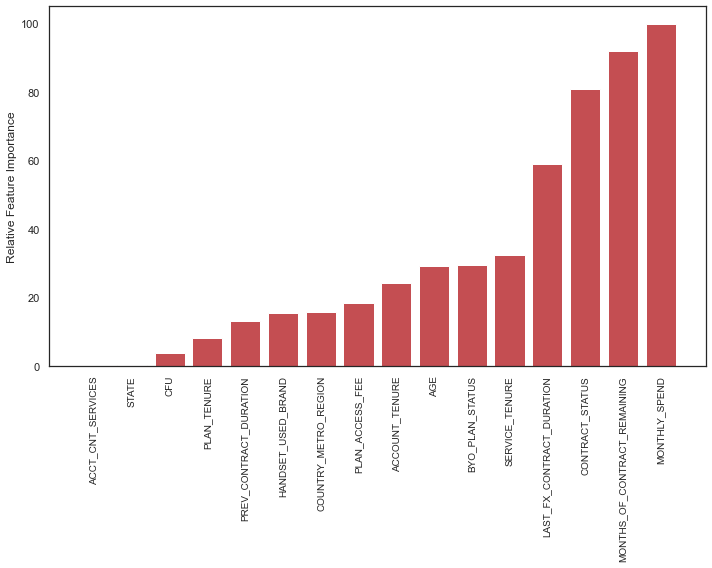

In [157]:
# Plot feature importance of all columns for the entire dataset
feature_importance = abs(model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,8))
featax = featfig.add_subplot(1, 1, 1)
featax.bar(pos, feature_importance[sorted_idx], align='center',color='r')
featax.set_xticks(pos)
featax.set_xticklabels(np.array(X.columns)[sorted_idx], fontsize=10, rotation=90)
featax.set_ylabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [158]:
# Build a logreg and compute the feature importances
model = LogisticRegression()
# Create the RFE model and select top 14 attributes
rfe = RFE(model, n_features_to_select=12)
rfe = rfe.fit(X_train, y_train)
# Summarize the selection of the attributes
print ('Total Number of features: ',len(X.columns))
print ('Total Number of Selected: ',len((X.columns[rfe.support_])))
print(' List of Selected features: %s' % list(X.columns[rfe.support_]))

Total Number of features:  16
Total Number of Selected:  12
 List of Selected features: ['ACCOUNT_TENURE', 'AGE', 'SERVICE_TENURE', 'PLAN_ACCESS_FEE', 'BYO_PLAN_STATUS', 'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'CONTRACT_STATUS', 'PREV_CONTRACT_DURATION', 'HANDSET_USED_BRAND', 'MONTHLY_SPEND', 'COUNTRY_METRO_REGION']


In [161]:
y_pred = rfe.predict(X_test,)

acc= accuracy_score(y_test, y_pred) 
print ('The accuracy of our model is {:3f} %'.format(acc * 100),)

The accuracy of our model is 72.134695 %


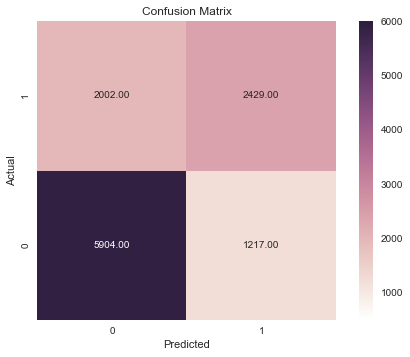

In [160]:
# Plot our confusion matrix
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
import matplotlib as mpl

mpl.style.use('seaborn')

conf_array = confusion_matrix(y_test, y_pred)

sum = conf_array.sum()

conf_arr = conf_array * 100.0 / ( 1.0 * sum )

df_cm = pd.DataFrame(conf_array, columns=np.unique(y_test), index = np.unique(y_pred))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig = plt.figure()

plt.clf()

ax = fig.add_subplot(111)
ax.set_aspect(1)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

res = sns.heatmap(df_cm, annot=True, vmin=500.0, vmax=6000.0, fmt='.2f', cmap=cmap)

res.invert_yaxis()
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.title('Confusion Matrix');